In [2]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'


In [4]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_sw_multifield'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [5]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False).iloc[:1000]
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
reload(sdos)
import get_all_switch_add_metrics as gasam
reload(gasam)

import preprocess_one_session as prepos

In [7]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all = prepped_data_agg['var_res_all']
corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']


ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])

ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 

# given multifield, one field pop up, can it predict the other field

awkward: has to join 0/1 and both each seperately, otherwise would miss multiple fields that has one on the central

In [8]:
%%time
import multi_field_analysis as mfa
reload(mfa)
has_sw_df = mfa.get_sw_multifield_info(changes_df_all,all_fields_recombined_all,level=(0,1,2,3,4))

/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_both_part['other_field_index']=field_index_for_both_from_another_tt


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 6.67 s, sys: 887 ms, total: 7.55 s
Wall time: 14.1 s


In [583]:
# multiple_field_l = []
# for k,val in has_sw_df.groupby(level=(0,1,2,3,4),sort=False):
# #     has_sw_df.loc[val.index,'multiple_field']=val.count()>1
#     count_val=np.ones(val.shape[0],dtype=bool)*(val['on'].count()>1)
#     count_df=pd.DataFrame(count_val,index=val.index)
#     multiple_field_l.append(count_df)
# multiple_field_l = pd.concat(multiple_field_l)

In [7]:
has_sw_df

on    off  multiple_field  other_on  \
e13_26m1 e13_26m1_210913 0 0 3  0.0   True  False           False     False   
                             27 0.0  False  False           False     False   
                             29 0.0   True   True            True     False   
                                1.0  False  False            True      True   
                                2.0  False  False            True      True   
...                                    ...    ...             ...       ...   
e14_2m3  e14_2m3_201118  0 1 30 0.0  False  False            True     False   
                             32 0.0  False  False            True     False   
                             38 0.0  False  False            True     False   
                             47 0.0  False  False            True     False   
                             53 0.0  False  False           False     False   

                                     other_off  
e13_26m1 e13_26m1_210913 0 0 3  0.0      False  
                             27 0.0      False  
                             29 0.0      False  
                                1.0       True  
                                2.0       True  
...                                        ...  
e14_2m3  e14_2m3_201118  0 1 30 0.0      False  
                             32 0.0      False  
                             38 0.0      False  
                             47 0.0      False  
                             53 0.0      False  

[15719 rows x 5 columns]

In [6]:
has_sw_df.loc[((has_sw_df['multiple_field']==False)&((has_sw_df['other_on']==True)))]

,,,,,,on,off,multiple_field,other_on,other_off


In [554]:
# df_all = has_sw_df
# df_merge_tt_both_d = {}
# trial_type_l=[0,1]
# for tt in trial_type_l:
#     if tt==0:
#         df_merge_tt_both=df_all.loc[(slice(None),slice(None),slice(None),[tt,'both']),:].reset_index(level=3,drop=True)
#     else:
#         df_both_part=df_all.loc[(slice(None),slice(None),slice(None),'both'),:]
#         df_tt_part = df_all.loc[(slice(None),slice(None),slice(None),tt),:]
#         inds=df_both_part.index
#         field_index_for_both_from_another_tt=all_fields_recombined_all.loc[inds]['other_field_index']
#         df_both_part['other_field_index']=field_index_for_both_from_another_tt
#         df_both_part=df_both_part.droplevel(-1)
#         df_both_part=df_both_part.set_index('other_field_index',append=True)
#         df_both_part=df_both_part.rename_axis([None]*6)
#         df_merge_tt_both = pd.concat([df_tt_part,df_both_part],axis=0).reset_index(level=3,drop=True)
#     df_merge_tt_both['trialtype']=tt
#     # tt_l=np.ones(df_merge_tt_both.shape[0])*tt
#     # df_merge_tt_both.reindex(tt_l,level=3)
#     df_merge_tt_both.set_index('trialtype',append=True)
#     df_merge_tt_both_d[tt] = df_merge_tt_both
# df_merge_tt_both_d = pd.concat(df_merge_tt_both_d,axis=0)
# df_merge_tt_both_d = df_merge_tt_both_d.swaplevel(0,1).swaplevel(1,2).swaplevel(2,3)
# df_merge_tt_both_d = df_merge_tt_both_d.drop('trialtype',axis=1)

/tmp/ipykernel_791413/3365048075.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_both_part['other_field_index']=field_index_for_both_from_another_tt


In [492]:
# %%time
# reload(mfa)
# other_field_sw=mfa.get_whether_other_field_sw(has_sw_df,cols=['on','off'])

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 4.84 s, sys: 1.5 s, total: 6.34 s
Wall time: 22.4 s


In [616]:
%%time
reload(mfa)
# index=has_sw_df.index
# resample_one=has_sw_df[['on']].sample(frac=1,replace=False)
# resample_one.index=index
# mfa.get_whether_other_field_sw(resample_one,cols=['on'])

has_sw_on = (changes_df_all==1).any(axis=1)
has_sw_off = (changes_df_all==-1).any(axis=1)

has_sw_df_pre_combine=pd.concat({'on':has_sw_on,'off':has_sw_off},axis=1)


resample_one_df_l = mfa.shuffle_has_sw_df(has_sw_df_pre_combine,all_fields_recombined_all,nrepeats=200,do_combine_tt_with_both=True)
fn_full=os.path.join(data_dir,'has_sw_df_shuffle_combine_tt_with_both.p')
resample_one_df_l.to_pickle(fn_full)

/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d
/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return df_merge_tt_both_d


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 17min 21s, sys: 5min 50s, total: 23min 12s
Wall time: 1h 20min 58s


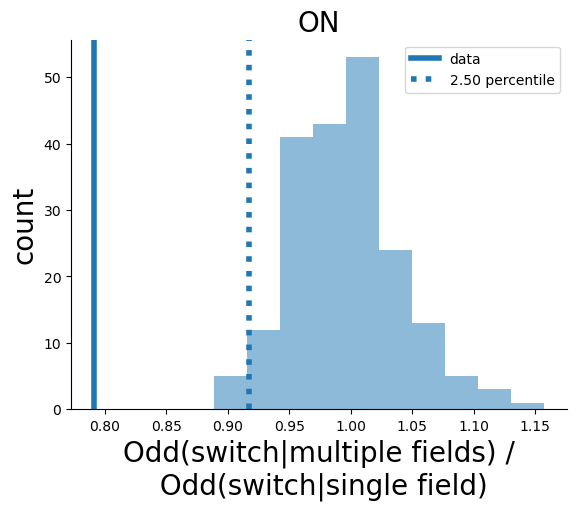

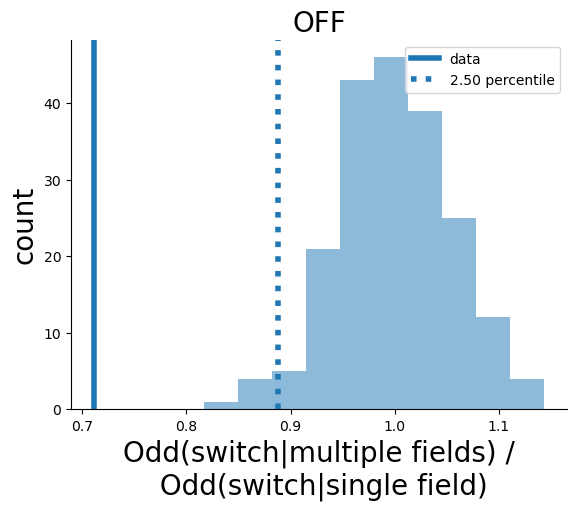

In [617]:
reload(ph)
x='multiple_field'
for y in ['on','off']:
#     y='on'
    odds_ratio_sh_l = []
    # resample_one_df_l_multi_field=resample_one_df_l.loc[resample_one_df_l.loc[:,(0,'multiple_field')]]
    df_shuffle_l = resample_one_df_l
    for k,val in df_shuffle_l.groupby(level=0,axis=1,group_keys=False):
        odds_ratio_sh=mfa.get_odds_ratio(val.loc[:,k],x=x,y=y)
        odds_ratio_sh_l.append(odds_ratio_sh)
    odds_ratio_sh_l = np.array(odds_ratio_sh_l)

    # has_sw_df_multifield=has_sw_df.loc[has_sw_df['multiple_field']]
    # odds_ratio = get_odds_ratio(has_sw_df,x,y)
    df=has_sw_df
    odds_ratio = mfa.get_odds_ratio(df,x,y)
#     fig,ax=plt.subplots(figsize=(8,4))
    fig,ax=ph.plot_shuffle_data_dist_with_thresh(odds_ratio_sh_l,odds_ratio,plot_ci_low=True)
    sns.despine()
    ax.set(xlabel=f'Odd(switch|multiple fields) /\n Odd(switch|single field)',ylabel='count',title=y.upper())
    
    for fmt in ['png','svg']:
        fn_full=os.path.join(figdir,f'odd_ratio_sw_{y}_vs_{x}.{fmt}')
        fig.savefig(fn_full,bbox_inches='tight')
        


/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

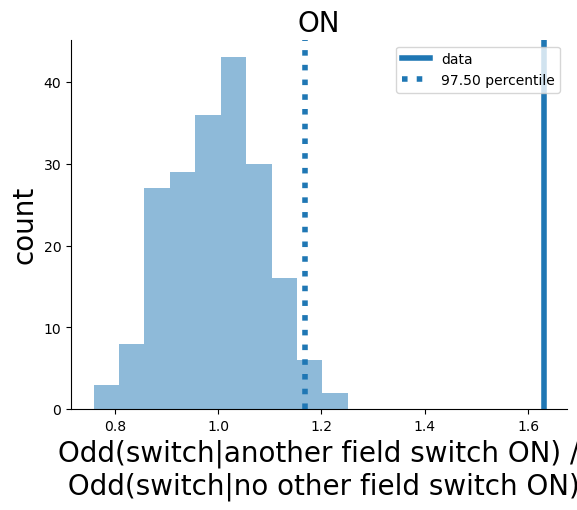

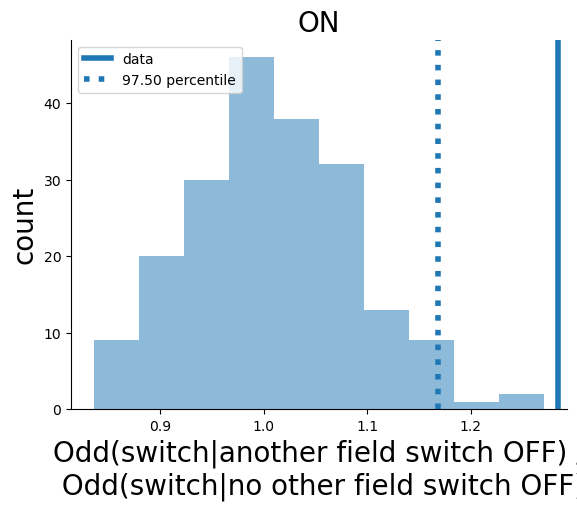

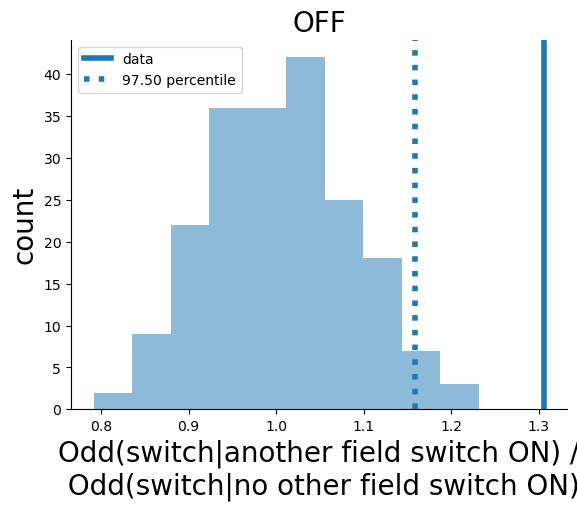

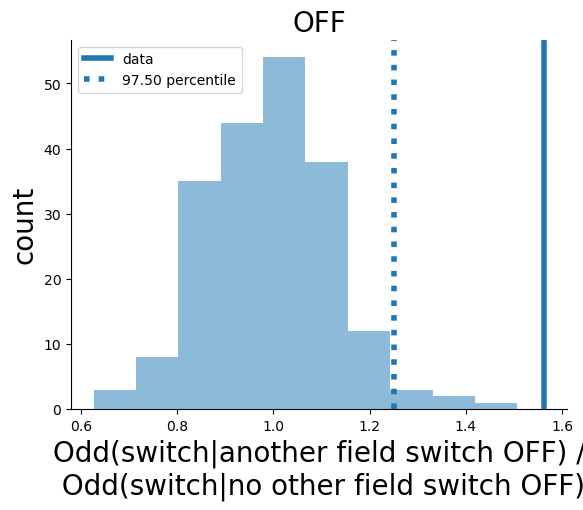

In [618]:
# x='other_on'
# y='on'

for onoff in ['on','off']:
    y = onoff
    for other_onoff in ['on','off']:
        x=f'other_{other_onoff}'
        x_str_pos=f'another field switch {other_onoff.upper()}'
        x_str_neg=f'no other field switch {other_onoff.upper()}'
        odds_ratio_sh_l = []
        resample_one_df_l_multi_field=resample_one_df_l.loc[resample_one_df_l.loc[:,(0,'multiple_field')].astype(bool)]
        df_shuffle_l = resample_one_df_l_multi_field
        for k,val in df_shuffle_l.groupby(level=0,axis=1,group_keys=False):
            odds_ratio_sh=mfa.get_odds_ratio(val.loc[:,k],x=x,y=y)
            odds_ratio_sh_l.append(odds_ratio_sh)
        odds_ratio_sh_l = np.array(odds_ratio_sh_l)

        has_sw_df_multifield=has_sw_df.loc[has_sw_df['multiple_field'].astype(bool)]
        # odds_ratio = get_odds_ratio(has_sw_df,x,y)
        odds_ratio = mfa.get_odds_ratio(has_sw_df_multifield,x,y)
        fig,ax=ph.plot_shuffle_data_dist_with_thresh(odds_ratio_sh_l,odds_ratio)
        
        sns.despine()
        ax.set(xlabel=f'Odd(switch|{x_str_pos}) /\n Odd(switch|{x_str_neg})',ylabel='count',title=y.upper())

        for fmt in ['png','svg']:
            fn_full=os.path.join(figdir,f'multi_field_only_odd_ratio_sw_{y}_vs_{x}.{fmt}')
            fig.savefig(fn_full,bbox_inches='tight')



Chi2ContingencyResult(statistic=63.99848825835662, pvalue=1.2451471974808607e-15, dof=1, expected_freq=array([[7093.43809163, 1846.56190837],
       [1288.56190837,  335.43809163]]))
Chi2ContingencyResult(statistic=10.690607992727859, pvalue=0.0010768081094188542, dof=1, expected_freq=array([[7784.84096933, 1155.15903067],
       [1414.15903067,  209.84096933]]))
Chi2ContingencyResult(statistic=11.566326045937572, pvalue=0.0006715697971911484, dof=1, expected_freq=array([[7597.278493, 1977.721507],
       [ 784.721507,  204.278493]]))
Chi2ContingencyResult(statistic=25.494441657883304, pvalue=4.436592327903821e-07, dof=1, expected_freq=array([[8337.79108292, 1237.20891708],
       [ 861.20891708,  127.79108292]]))


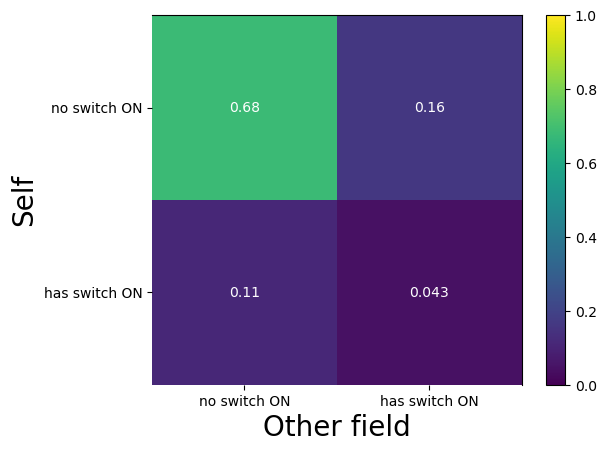

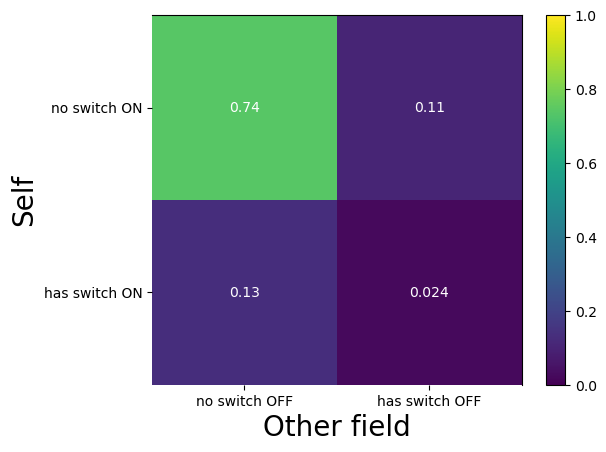

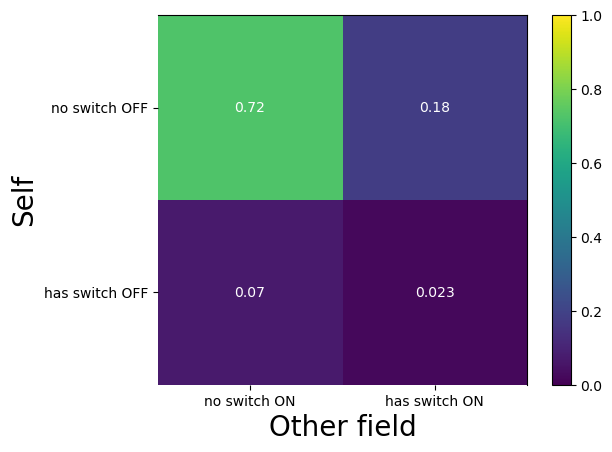

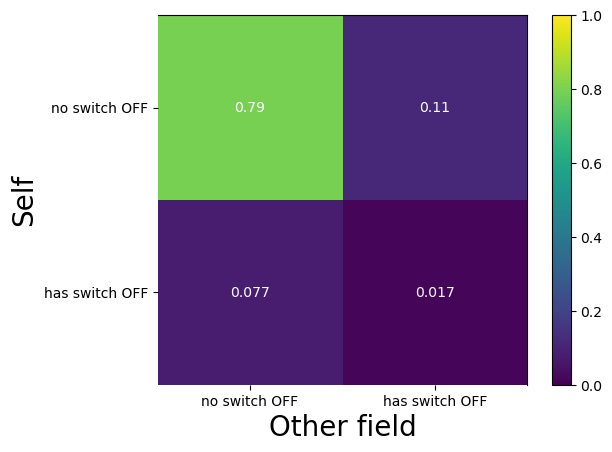

In [588]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

has_sw_df_multifield=has_sw_df.loc[has_sw_df['multiple_field'].astype(bool)]

for self_onoff in ['on','off']:
    for other_onoff in ['on','off']:
        
        conf_mat=confusion_matrix(has_sw_df_multifield[self_onoff],has_sw_df_multifield[f'other_{other_onoff}'])
        conf_mat_norm=confusion_matrix(has_sw_df_multifield[self_onoff],has_sw_df_multifield[f'other_{other_onoff}'],normalize='all')
        disp=ConfusionMatrixDisplay(conf_mat_norm)
        disp=disp.plot()
        ax=disp.ax_
        disp.im_.set_clim([0,1])
        [x.set_color('white') for x in disp.text_.ravel()]

        ax.spines[['left','bottom']].set_visible(False)
        ax.set(xlabel='Other field',ylabel='Self')
        ticks = [0,1]
        yticklabels=[f'no switch {self_onoff.upper()}',f'has switch {self_onoff.upper()}']
        xticklabels=[f'no switch {other_onoff.upper()}',f'has switch {other_onoff.upper()}']
        ax.set(xticks=ticks,yticks=ticks,xticklabels=xticklabels,yticklabels=yticklabels)
        fig=ax.figure

        print(scipy.stats.chi2_contingency(conf_mat))
        
        for fmt in ['png','svg']:
            fig_fn = f'multifield_self_{self_onoff}_vs_other_{other_onoff}.{fmt}'
            fig_fn = os.path.join(figdir,fig_fn)
            fig.savefig(fig_fn,bbox_inches='tight')



In [53]:
changes_df_all_combine_tt_both = mfa.combine_trial_type_with_both(changes_df_all,all_fields_recombined_all)



/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_both_part['other_field_index']=field_index_for_both_from_another_tt


In [54]:
for k,val in has_sw_df.groupby(level=(0,1,2,3,4)):
    assert val['multiple_field'][0]==(val.shape[0]>1)
    if val['on'].sum()==1:
        assert (val['on'] != val['other_on']).all()
    elif val['on'].sum()>1:
        assert val['other_on'].all()
    assert np.all(val['on'].values== ((changes_df_all_combine_tt_both.loc[k]==1).sum(axis=1)>0).values)

    

/tmp/ipykernel_1643187/788527247.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  assert np.all(val['on'].values== ((changes_df_all_combine_tt_both.loc[k]==1).sum(axis=1)>0).values)


In [55]:
from statannotations.Annotator import Annotator

In [21]:
has_sw_df.groupby(['multiple_field','other_on']).count()

on   off  other_off
multiple_field other_on                       
False          False     5155  5155       5155
True           False     8382  8382       8382
               True      2182  2182       2182

In [22]:
has_sw_df.groupby(['multiple_field','other_off']).count()

on   off  other_on
multiple_field other_off                      
False          False      5155  5155      5155
True           False      9199  9199      9199
               True       1365  1365      1365

In [30]:
mean.columns

MultiIndex([(False, False),
            ( True, False),
            ( True,  True)],
           name='off')

In [43]:
mean.melt()

,multiple_field,other_on,value
0,False,False,0.134328
1,False,False,0.115942
2,False,False,0.114286
3,False,False,0.058824
4,False,False,0.111111
...,...,...,...
133,True,True,0.153846
134,True,True,0.186047
135,True,True,0.235294
136,True,True,0.175439


In [46]:
mean.melt()

,variable,value
0,0,0.059701
1,0,0.014493
2,0,0.085714
3,0,0.058824
4,0,0.074074
...,...,...
133,2,0.150000
134,2,0.064516
135,2,0.076923
136,2,0.093023


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Wilcoxon test (paired samples), P_val:2.494e-01 Stat=4.340e+02
1 vs. 2: Wilcoxon test (paired samples), P_val:3.409e-02 Stat=3.470e+02


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Wilcoxon test (paired samples), P_val:8.881e-01 Stat=5.270e+02
1 vs. 2: Wilcoxon test (paired samples), P_val:8.258e-01 Stat=4.980e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Wilcoxon test (paired samples), P_val:2.362e-01 Stat=4.310e+02
1 vs. 2: Wilcoxon test (paired samples), P_val:7.291e-01 Stat=5.080e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Wilcoxon test (paired samples), P_val:3.289e-01 Stat=4.310e+02


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


1 vs. 2: Wilcoxon test (paired samples), P_val:4.480e-01 Stat=4.700e+02


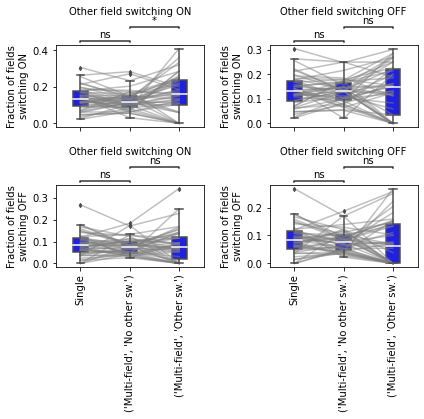

In [77]:
from statannotations.Annotator import Annotator
fig,axs=plt.subplots(2,2,figsize=(6,6))
multifield_map = {True:'Multi-field',False:'Single'}
other_switch_map = {True:'Other sw.',False:'No other sw.'}
data = has_sw_df.loc[(slice(None),slice(None),0),:]
for ii,y_key in enumerate(['on','off']):
    for jj, groupkey in enumerate(['on','off']):
        ax=axs[ii,jj]
        mean = data.groupby(level=(1,2)).apply(lambda x:x.groupby(['multiple_field',f'other_{groupkey}'])[f'{y_key}'].mean())
        cols = mean.columns
        mean.columns = np.arange(mean.shape[1])
        xticklabels=[]
        mean.melt()
        for col in cols:
            if not col[0]:
                xl = multifield_map[col[0]]
            else:
                xl = (multifield_map[col[0]],other_switch_map[col[1]])
            xticklabels.append(xl)
        for i,row in mean.iterrows():
            ax.plot(np.arange(len(row)),row.values,c='grey',alpha=0.5)
        ax=sns.boxplot(data=mean,ax=ax,width=0.3, linewidth=1.5, fliersize=3, palette=["blue"],
                       medianprops={'c':'white'}
                      )
        pairs=[[0,1],[1,2]]
        annotator = Annotator(ax, pairs, data=mean)
        annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
        annotator.apply_and_annotate()
        if ii==1:
            ax.set_xticklabels(xticklabels,rotation=90)
        else:
            ax.set_xticklabels([])
        ax.set_ylabel(f'Fraction of fields\nswitching {y_key.upper()}')
        ax.set_title(f'Other field switching {groupkey.upper()}',pad=30)

plt.tight_layout()
figfn = f'frac_sw_vs_multiple_field_other_field_sw'
ph.save_given_name(fig,figfn,figdir)

        



In [78]:
mean.shape

(46, 3)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True_False vs. True_True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.525e-16 U_stat=8.508e+06
False_False vs. True_False: Mann-Whitney-Wilcoxon test two-sided, P_val:1.805e-13 U_stat=2.263e+07
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True_False vs. True_True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.340e-04 U_stat=6.061e+06
False_False vs. True_False: Mann-Whitney-Wilcoxon test two-sided, P_val:4.997e-09 U_stat=2.460e+07
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True_False vs. True_True: Mann-Whitney-Wilcoxon test two-sided, P

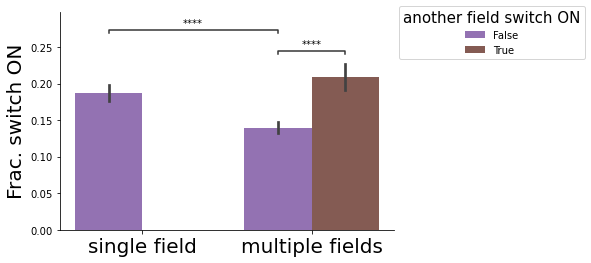

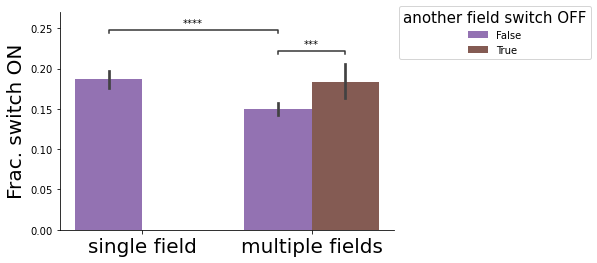

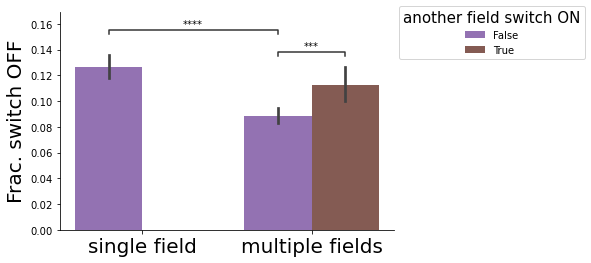

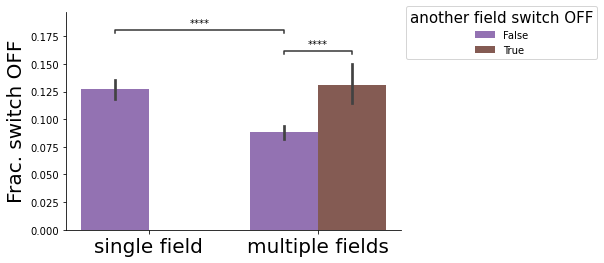

In [67]:
data=has_sw_df
x = 'multiple_field'
palette = {0:'C4',1:'C5'}
for onoff_str in ['on','off']:
    for other_onoff_str in ['on','off']:
        other_onoff_str_plot=f'another field switch {other_onoff_str.upper()}'
        other_onoff_key = f'other_{other_onoff_str}'
        data[other_onoff_key] = data[other_onoff_key].astype(bool)
        fig,ax=plt.subplots()
        ax=sns.barplot(data=data,x=x,y=onoff_str,hue=other_onoff_key,ax=ax,order=[0,1],palette=palette)
        sns.despine()
        ax.set_xticklabels(['single field','multiple fields'],fontsize=20)
        ax.set(xlabel="",ylabel=f'Frac. switch {onoff_str.upper()}')
        l=ax.get_legend()
        l.set_title(other_onoff_str_plot)
        plt.setp(l.get_title(),fontsize=15)
        l.set(bbox_to_anchor=[1,1.05])
        
        

        # pairs = [(0,2),(1,2),(0,1)]
        pairs = [
            ((0,False),(1,False)),
            ((1,False),(1,True)),
        ]
        annotator = Annotator(ax, pairs, data=data, x=x,hue=other_onoff_key, y=onoff_str)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
        annotator.apply_and_annotate()

        
        for fmt in ['png','svg']:
            fn_full=os.path.join(figdir,f'frac_sw_{onoff_str}_vs_multiple_field_hue_{other_onoff_key}.{fmt}')
            fig.savefig(fn_full,bbox_inches='tight')

        

In [383]:
import pingouin as pg

In [384]:
fr_mean_all_fields=pf_params_recombined_all.loc[(slice(None),slice(None),'fr_mean')].mean(axis=1)

has_sw_df_with_fr = has_sw_df.join(fr_mean_all_fields.to_frame(name='fr'))

In [151]:
has_sw_df_with_fr['on']=has_sw_df_with_fr['on'].astype(int)

In [152]:
pg.ancova(data=has_sw_df_with_fr,dv='on',between='other_on',covar='fr')

,Source,SS,DF,F,p-unc,np2
0,other_on,0.778788,1,5.901433,1.514069e-02,0.000409
1,fr,4.480057,1,33.948601,5.779344e-09,0.002346
2,Residual,1904.927489,14435,NaN,NaN,NaN


<Axes: xlabel='off', ylabel='fr'>

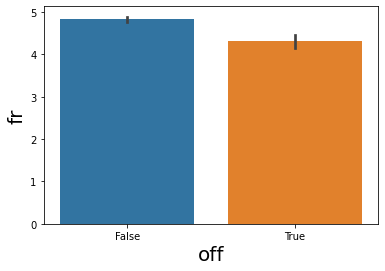

In [156]:
sns.barplot(data=has_sw_df_with_fr,x='off',y='fr')

# does multifield switch happen in the same or adjacent trial

In [ ]:
# currently using changes df to find nonzero terms occurring on the same trial for pairs of fields. 
# The annoying part is always combining the "both" and side arms. 
# the result is there are so little. That it's not worth counting. 
# But again given the inaccuracies of the detection, might be a problem


In [44]:
gpb = changes_df_all.groupby(level=(0,1,2,4),sort=False)
field_pair_same_trial_all = {}
npairs_tot = 0
for k,val in gpb:
    nr =val.shape[0]
    valval=(val.values!=0)&np.logical_not((np.isnan(val.values)))
    if nr>0:
        field_pair_same_trial = {}
        for nn in range(nr):
            for kk in range(nn+1,nr):
                same_trial = np.any(np.logical_and(valval[nn,:],valval[kk,:]))
                field_pair_same_trial[(nn,kk)] = same_trial
                if np.any(valval[nn,:]) & np.any(valval[kk,:]):
                    npairs_tot = npairs_tot+1
    field_pair_same_trial_all[k] = field_pair_same_trial
field_pair_same_trial_all = pd.DataFrame(field_pair_same_trial_all).T


In [45]:
npairs_tot # npairs, both switched

781

In [46]:
field_pair_same_trial_all.sum().sum()

41

In [47]:
field_pair_same_trial_all.sum().sum()/npairs_tot

0.052496798975672214

In [24]:
field_pair_same_trial_all

0                           1         \
                                   1      2      3      4      2      3   
e13_26m1 e13_26m1_210913 0 3   False    NaN    NaN    NaN    NaN    NaN   
                           27  False    NaN    NaN    NaN    NaN    NaN   
                           29  False  False  False  False  False  False   
                           30  False  False  False    NaN  False  False   
                           31  False    NaN    NaN    NaN    NaN    NaN   
...                              ...    ...    ...    ...    ...    ...   
e14_2m3  e14_2m3_201118  0 47  False  False  False    NaN  False  False   
                           48  False    NaN    NaN    NaN    NaN    NaN   
                           50  False  False    NaN    NaN  False    NaN   
                           53  False  False    NaN    NaN  False    NaN   
                           40    NaN    NaN    NaN    NaN    NaN    NaN   

                                          2             3  ...    5    6    0  \
                                   4      3      4      4  ...    7    7    8   
e13_26m1 e13_26m1_210913 0 3     NaN    NaN    NaN    NaN  ...  NaN  NaN  NaN   
                           27    NaN    NaN    NaN    NaN  ...  NaN  NaN  NaN   
                           29  False  False  False  False  ...  NaN  NaN  NaN   
                           30    NaN  False    NaN    NaN  ...  NaN  NaN  NaN   
                           31    NaN    NaN    NaN    NaN  ...  NaN  NaN  NaN   
...                              ...    ...    ...    ...  ...  ...  ...  ...   
e14_2m3  e14_2m3_201118  0 47    NaN  False    NaN    NaN  ...  NaN  NaN  NaN   
                           48    NaN    NaN    NaN    NaN  ...  NaN  NaN  NaN   
                           50    NaN    NaN    NaN    NaN  ...  NaN  NaN  NaN   
                           53    NaN    NaN    NaN    NaN  ...  NaN  NaN  NaN   
                           40    NaN    NaN    NaN    NaN  ...  NaN  NaN  NaN   

                                 1    2    3    4    5    6    7  
                                 8    8    8    8    8    8    8  
e13_26m1 e13_26m1_210913 0 3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                           27  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                           29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                           30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                           31  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...                            ...  ...  ...  ...  ...  ...  ...  
e14_2m3  e14_2m3_201118  0 47  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                           48  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                           50  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                           53  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
                           40  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5538 rows x 36 columns]

# examples

In [84]:
import plot_all_fr_map_x_pwc_one_session as plot_fm
reload(plot_fm)

<module 'plot_all_fr_map_x_pwc_one_session' from '/mnt/home/szheng/projects/place_variability/code/plot_all_fr_map_x_pwc_one_session.py'>

In [80]:
subdir = 'multifield_ratemap_ex'
subdir = misc.get_or_create_subdir(figdir,subdir)

In [71]:
reload(plot_fm)

<module 'plot_all_fr_map_x_pwc_one_session' from '/mnt/home/szheng/projects/place_variability/code/plot_all_fr_map_x_pwc_one_session.py'>

In [81]:
ani='e13_26m1'
sess='e13_26m1_210913'

In [82]:

fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
all_fields = all_fields_recombined_all.loc[ani,sess]
changes_df = changes_df_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]
index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)
has_sw_df_sub = has_sw_df.loc[ani,sess]



/tmp/ipykernel_185943/2587345420.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_185943/2587345420.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_185943/2587345420.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[ani,sess]
/tmp/ipykernel_185943/2587345420.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]
/tmp/ipykernel_185943/2587345420.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_sw_df_sub = has_sw_df.loc[ani,sess]


In [89]:
reload(plot_fm)

<module 'plot_all_fr_map_x_pwc_one_session' from '/mnt/home/szheng/projects/place_variability/code/plot_all_fr_map_x_pwc_one_session.py'>

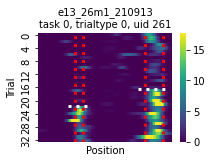

In [104]:
# both fields ON
ma = has_sw_df_sub['other_on'] & has_sw_df_sub['on']
ii=10
task_ind,tt,uid,field_id = has_sw_df_sub.loc[ma].iloc[ii].name

fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=False,
                                       fig=None,ax=None,shuffle_ratemap=False,vmax_clip_quantile=0.99,figsize=(3,2)
                                      )
title = f'{sess}\ntask {task_ind}, trialtype {tt}, uid {uid}'
ax.set_title(title)
for fmt in ['png','svg']:
    fn_full = os.path.join(subdir,f'multi_on_{sess}_task_{task_ind}_tt_{tt}_uid_{uid}.{fmt}')
    fig.savefig(fn_full,bbox_inches='tight')

In [86]:
reload(sdos)

<module 'switch_detection_one_session' from '/mnt/home/szheng/projects/place_variability/code/switch_detection_one_session.py'>

In [89]:
# %%time
# pval_all_mean = {}
# best_n_all_mean = {}
# X_pwc_all_mean = {}
# X_raw_all_mean = {}
# changes_df_all_mean = {}
# var_res_all_mean = {}
# corr_all_mean = {}

# for ind,row in subdb.iterrows():
#     data_dir_full = row['data_dir_full']
#     ani = ind[0]
#     sess = row['sess_name']
    
#     sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True,dosave=False)
#     pval = sw_res['pval']
#     pval_all_mean[ani,sess]=pval
#     best_n = sw_res['best_n']
#     best_n_all_mean[ani,sess] = best_n
#     X_pwc = sw_res['X_pwc']
#     X_pwc_all_mean[ani,sess] = X_pwc
#     X_raw = sw_res['X_raw']
#     X_raw_all_mean[ani,sess]=X_raw
#     changes_df = sw_res['changes_df']
#     changes_df_all_mean[ani,sess] = changes_df
#     var_res = sw_res['var_res']
#     var_res_all_mean[ani,sess]=var_res
#     corr = sw_res['corr']
#     corr_all_mean[ani,sess] = corr


# pval_all_mean = pd.concat(pval_all_mean,axis=0)
# X_pwc_all_mean = pd.concat(X_pwc_all_mean,axis=0)
# X_raw_all_mean = pd.concat(X_raw_all_mean,axis=0)
# changes_df_all_mean = pd.concat(changes_df_all_mean,axis=0)
# var_res_all_mean = pd.concat(var_res_all_mean,axis=0)
# corr_all_mean = pd.concat(corr_all_mean,axis=0)
# best_n_all_mean = pd.concat(best_n_all_mean,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng

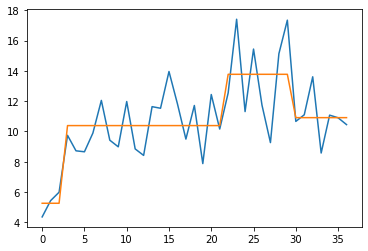

In [95]:
plt.plot(X_raw_all_mean.loc[(ani,sess,task_ind,tt,uid,1),:].dropna().values)
plt.plot(X_pwc_all_mean.loc[(ani,sess,task_ind,tt,uid,1),:].dropna().values)

In [96]:
changes_df.loc

0    1    2    3    4    5    6    7    8    9   ...   14   15  \
0 0.0  2  1  0.0  0.0  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  ...  0.0  NaN   
          2  0.0  0.0  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  ...  0.0  NaN   
          3  0.0  0.0  0.0  NaN  1.0  0.0  NaN  0.0  0.0  NaN  ...  0.0  NaN   
       3  1  0.0  0.0  0.0  NaN  0.0  0.0  NaN  0.0  0.0  NaN  ...  0.0  NaN   
       4  0  0.0  0.0  0.0  NaN  0.0  0.0  NaN  1.0  0.0  NaN  ...  0.0  NaN   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
  both 30 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       32 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       38 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       47 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
       53 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

              16   17   18   19   20   21   22   23  
0 0.0  2  1  0.0  0.0  NaN  0.0  NaN  0.0  NaN  NaN  
          2  0.0  0.0  NaN  1.0  NaN  0.0  NaN  NaN  
          3  0.0  0.0  NaN  0.0  NaN  0.0  NaN  NaN  
       3  1  0.0  0.0  NaN  0.0  NaN  0.0  NaN  NaN  
       4  0  0.0  0.0  NaN  0.0  NaN  0.0  NaN  NaN  
...          ...  ...  ...  ...  ...  ...  ...  ...  
  both 30 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       32 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       38 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       47 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
       53 0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[110 rows x 24 columns]

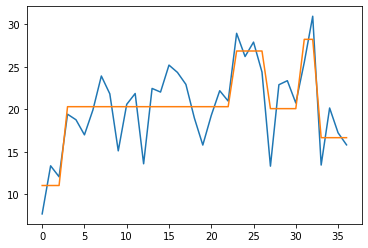

In [81]:
plt.plot(X_raw_all.loc[(ani,sess,task_ind,tt,uid,1),:].dropna().values)
plt.plot(X_pwc_all.loc[(ani,sess,task_ind,tt,uid,1),:].dropna().values)

In [93]:
reload(plot_fm)

<module 'plot_all_fr_map_x_pwc_one_session' from '/mnt/home/szheng/projects/place_variability/code/plot_all_fr_map_x_pwc_one_session.py'>

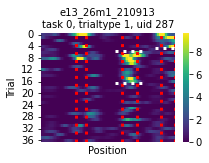

In [103]:
# both fields OFF
ma = has_sw_df_sub['other_off'] & has_sw_df_sub['off']
ii=26
task_ind,tt,uid,field_id = has_sw_df_sub.loc[ma].iloc[ii].name
# tt=1

fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=False,
                                       fig=None,ax=None,shuffle_ratemap=False,vmax_clip_quantile=0.99
                                      )
title = f'{sess}\ntask {task_ind}, trialtype {tt}, uid {uid}'
ax.set_title(title)
for fmt in ['png','svg']:
    fn_full = os.path.join(subdir,f'multi_off_{sess}_task_{task_ind}_tt_{tt}_uid_{uid}.{fmt}')
    fig.savefig(fn_full,bbox_inches='tight')

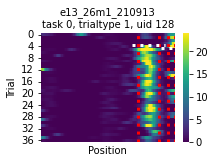

In [107]:
# one switch on and another off
ma = has_sw_df_sub['on'] & has_sw_df_sub['other_off']
ii=16 #12
task_ind,tt,uid,field_id = has_sw_df_sub.loc[ma].iloc[ii].name
# tt=1

fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=False,
                                       fig=None,ax=None,shuffle_ratemap=False,vmax_clip_quantile=0.99
                                      )
title = f'{sess}\ntask {task_ind}, trialtype {tt}, uid {uid}'
ax.set_title(title)
for fmt in ['png','svg']:
    fn_full = os.path.join(subdir,f'one_on_one_off_{sess}_task_{task_ind}_tt_{tt}_uid_{uid}.{fmt}')
    fig.savefig(fn_full,bbox_inches='tight')

In [153]:
import sw_and_int_one_sess as sios
ddf=subdb.query('sess_name==@sess')['data_dir_full'].iloc[0]
sw_int_res=sios.main(ddf,force_reload=False,load_only=True,dosave=False)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_and_int_pen_5e-01.p exists; loading---


<Axes: >

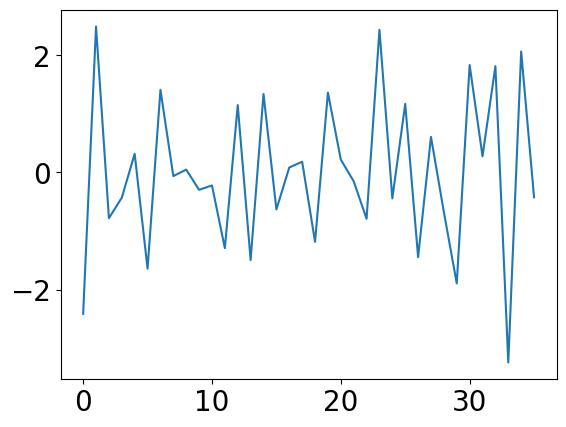

In [249]:
sw_int_res['consec_trial_fr_diff_all'].loc[tt,uid,0]['inh'].plot()

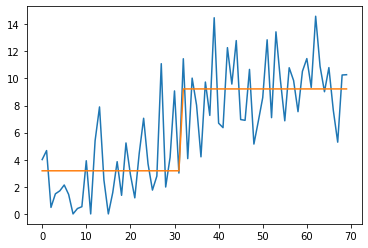

In [140]:
tt='both'
plt.plot(X_raw_all.loc[(ani,sess,task_ind,tt,uid,0),:].dropna().values)
plt.plot(X_pwc_all.loc[(ani,sess,task_ind,tt,uid,0),:].dropna().values)

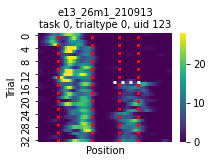

In [105]:
# one switch on and another no switch
ma = has_sw_df_sub['on'] & (~has_sw_df_sub['other_off']) &(~has_sw_df_sub['other_on']) & (has_sw_df_sub['multiple_field'])
ii=11 #5 
task_ind,tt,uid,field_id = has_sw_df_sub.loc[ma].iloc[ii].name
# tt=1

fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=False,
                                       fig=None,ax=None,shuffle_ratemap=False,vmax_clip_quantile=0.99
                                      )
title = f'{sess}\ntask {task_ind}, trialtype {tt}, uid {uid}'
ax.set_title(title)
for fmt in ['png','svg']:
    fn_full = os.path.join(subdir,f'one_on_other_nosw_{sess}_task_{task_ind}_tt_{tt}_uid_{uid}.{fmt}')
    fig.savefig(fn_full,bbox_inches='tight')

In [100]:
reload(plot_fm)

<module 'plot_all_fr_map_x_pwc_one_session' from '/mnt/home/szheng/projects/place_variability/code/plot_all_fr_map_x_pwc_one_session.py'>

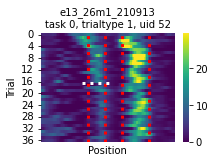

In [106]:
# one switch off and another no swtich
ma = has_sw_df_sub['off'] & (~has_sw_df_sub['other_off']) &(~has_sw_df_sub['other_on']) & (has_sw_df_sub['multiple_field'])
ii= 27#0 
task_ind,tt,uid,field_id = has_sw_df_sub.loc[ma].iloc[ii].name
# tt=1

fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=False,
                                       fig=None,ax=None,shuffle_ratemap=False,vmax_clip_quantile=0.99
                                      )
title = f'{sess}\ntask {task_ind}, trialtype {tt}, uid {uid}'
ax.set_title(title)
for fmt in ['png','svg']:
    fn_full = os.path.join(subdir,f'one_off_other_nosw_{sess}_task_{task_ind}_tt_{tt}_uid_{uid}.{fmt}')
    fig.savefig(fn_full,bbox_inches='tight')

In [228]:
pval_all.loc[ani,sess,task_ind,tt,uid,1]

1  pval                     0.055000
   exp_var_ratio            0.273489
   exp_var_ratio_sh_med     0.096727
   exp_var_ratio_sh_high    0.350177
   exp_var_ratio_sh_low     0.034458
2  pval                     0.211000
   exp_var_ratio            0.368179
   exp_var_ratio_sh_med     0.260576
   exp_var_ratio_sh_high    0.542186
   exp_var_ratio_sh_low     0.129904
3  pval                     0.335000
   exp_var_ratio            0.398376
   exp_var_ratio_sh_med     0.333961
   exp_var_ratio_sh_high    0.625179
   exp_var_ratio_sh_low     0.183766
4  pval                     0.420000
   exp_var_ratio            0.439890
   exp_var_ratio_sh_med     0.411730
   exp_var_ratio_sh_high    0.715030
   exp_var_ratio_sh_low     0.245496
5  pval                     0.411000
   exp_var_ratio            0.490851
   exp_var_ratio_sh_med     0.461350
   exp_var_ratio_sh_high    0.762695
   exp_var_ratio_sh_low     0.288367
Name: (e13_26m1, e13_26m1_210913, 0, 0.0, 262, 1), dtype: float64

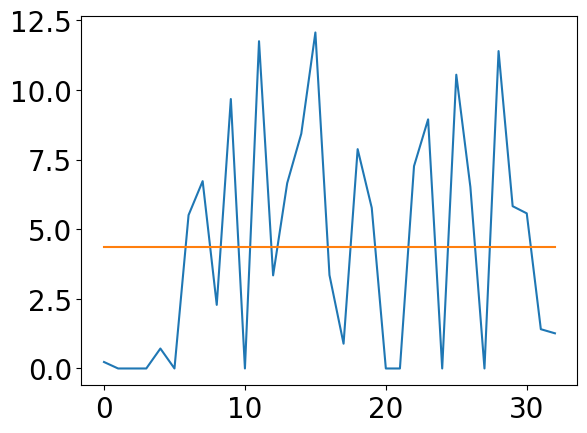

In [223]:
plt.plot(X_raw_all.loc[(ani,sess,task_ind,tt,uid,0),:].dropna().values)
plt.plot(X_pwc_all.loc[(ani,sess,task_ind,tt,uid,0),:].dropna().values)

<Axes: >

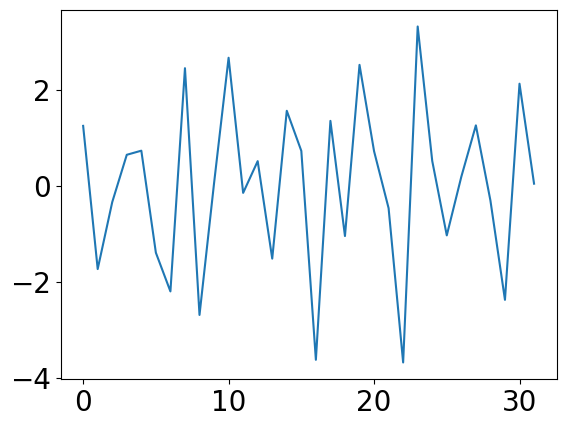

In [191]:
sw_int_res['consec_trial_fr_diff_all'].loc[tt,uid,1]['inh'].plot()

# old examples

/tmp/ipykernel_1128008/1684755911.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/1684755911.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_1128008/1684755911.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/1684755911.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


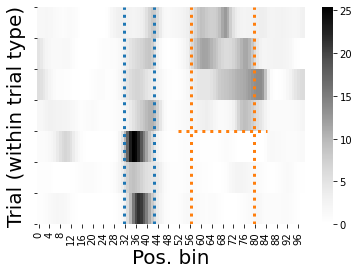

In [42]:
# multiple field, only one switch on
reload(plot_fm)
gpb=has_sw_df.query('multiple_field>0').groupby(level=(0,1,2,3,4))
n_sw_within_neuron=gpb['on'].sum()
ma=n_sw_within_neuron==1
ii=24
ani,sess,task_ind,tt,uid=n_sw_within_neuron.loc[ma].index[ii]
fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
all_fields = all_fields_recombined_all.loc[ani,sess]
changes_df = changes_df_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]
index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)

fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=True,
                                       fig=None,ax=None,shuffle_ratemap=False
                                      )
for fmt in ['png','svg']:
    fn_full = os.path.join(subdir,f'single_on_{sess}_task_{task_ind}_tt_{tt}_uid_{uid}.{fmt}')

/tmp/ipykernel_1128008/2800174472.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/2800174472.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_1128008/2800174472.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/2800174472.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


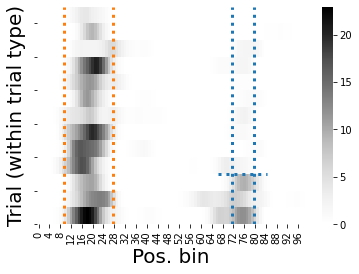

In [111]:
# multiple fields, only one OFF
reload(plot_fm)

good_sw_off=all_sw_with_metrics_d_all.query('switch==-1&post_mean_fr_3_norm<0.5&post_ntrials_in_segment>=10&post_ntrial_le_30_perc_frac_total>0.7')
good_sw_off_ind=good_sw_off.droplevel(-1).set_index('trialtype',append=True).set_index('uid',append=True).index


gpb=has_sw_df.query('multiple_field>0').groupby(level=(0,1,2,3,4))
n_sw_within_neuron=gpb['off'].sum()
ma=n_sw_within_neuron==1
ii=17
# ani,sess,task_ind,tt,uid=n_sw_within_neuron.loc[ma].index[ii]
# ani='e13_26m1'
ind = n_sw_within_neuron.loc[ma].index.intersection(good_sw_off_ind)
ani,sess,task_ind,tt,uid = ind[ii]
fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
all_fields = all_fields_recombined_all.loc[ani,sess]
changes_df = changes_df_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]
index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)

fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=True,
                                       fig=None,ax=None,shuffle_ratemap=False
                                      )
for fmt in ['png','svg']:
    fn_full = os.path.join(subdir,f'single_off_{sess}_task_{task_ind}_tt_{tt}_uid_{uid}.{fmt}')

/tmp/ipykernel_1128008/2766067431.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/2766067431.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_1128008/2766067431.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/2766067431.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


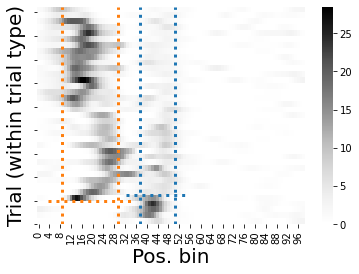

In [283]:
# multi field one ON one OFF

reload(plot_fm)

good_sw_off=all_sw_with_metrics_d_all.query('switch==-1&post_mean_fr_3_norm<0.5&post_ntrials_in_segment>=5&post_ntrial_le_30_perc_frac_total>0.7')
good_sw_on=all_sw_with_metrics_d_all.query('switch==1&post_mean_fr_3_norm>0.5&post_ntrials_in_segment>=5&post_ntrial_ge_70_perc_frac_total>0.7')
good_sw_onoff = pd.concat([good_sw_on,good_sw_off],axis=0)
good_sw_onoff_ind=good_sw_onoff.droplevel(-1).set_index('trialtype',append=True).set_index('uid',append=True).index


gpb=has_sw_df.query('multiple_field>0').groupby(level=(0,1,2,3,4))
ma=((gpb['off'].sum())>0)&((gpb['on'].sum())>0)

ii=2
# ani,sess,task_ind,tt,uid=n_sw_within_neuron.loc[ma].index[ii]
# ani='e13_26m1'
ind = n_sw_within_neuron.loc[ma].index.intersection(good_sw_onoff_ind)
ani,sess,task_ind,tt,uid = ind[ii]
fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
all_fields = all_fields_recombined_all.loc[ani,sess]
changes_df = changes_df_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]
index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)

fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                       task_ind,tt,uid,flipy=True,
                                       fig=None,ax=None,shuffle_ratemap=False
                                      )
for fmt in ['png','svg']:
    fn_full = os.path.join(subdir,f'on_off_{sess}_task_{task_ind}_tt_{tt}_uid_{uid}.{fmt}')


# test whether pop up in one field is associated with a drop in FR for the other

In [ ]:
# first try all two field neurons


In [130]:
fr_peak_all

0          1          2   \
e13_26m1 e13_26m1_210913 fr_peak 0 0.0  3  0       NaN   2.726724        NaN   
                                        27 0       NaN  25.437013        NaN   
                                        29 0       NaN   6.552950        NaN   
                                           1       NaN  25.426426        NaN   
                                           2       NaN   6.629354        NaN   
...                                                ...        ...        ...   
e14_2m3  e14_2m3_201118  fr_peak 0 both 30 0  5.095494   3.864507   9.746602   
                                        32 0  2.438889   1.569897  17.921236   
                                        38 0  0.884345   1.884227  16.165202   
                                        47 0  2.883682   4.555693   8.298331   
                                        53 0  3.412700   1.475201   9.103665   

                                                     3          4          5   \
e13_26m1 e13_26m1_210913 fr_peak 0 0.0  3  0   6.556670        NaN        NaN   
                                        27 0  21.112812        NaN        NaN   
                                        29 0  11.096927        NaN        NaN   
                                           1  22.606144        NaN        NaN   
                                           2  31.612912        NaN        NaN   
...                                                 ...        ...        ...   
e14_2m3  e14_2m3_201118  fr_peak 0 both 30 0   5.638320   5.118438   8.566871   
                                        32 0  21.449069  14.816101  12.645286   
                                        38 0  14.647532   5.757225  28.597693   
                                        47 0   3.678939   3.372170   4.532741   
                                        53 0   3.758584   3.861660  11.022403   

                                                     6          7          8   \
e13_26m1 e13_26m1_210913 fr_peak 0 0.0  3  0   2.604235        NaN   0.000000   
                                        27 0  35.841307        NaN  29.787902   
                                        29 0  12.231089        NaN   9.724030   
                                           1  34.580452        NaN  33.254925   
                                           2  20.232920        NaN  11.154519   
...                                                 ...        ...        ...   
e14_2m3  e14_2m3_201118  fr_peak 0 both 30 0  14.377560  14.960133   8.316371   
                                        32 0   9.686196   7.983908   7.295007   
                                        38 0  16.729104  19.865944   7.576131   
                                        47 0  11.923504   8.908769   6.323046   
                                        53 0   0.042268   1.760345   1.992621   

                                                    9   ...  60         61  \
e13_26m1 e13_26m1_210913 fr_peak 0 0.0  3  0       NaN  ... NaN   4.049848   
                                        27 0       NaN  ... NaN  39.647722   
                                        29 0       NaN  ... NaN   0.460175   
                                           1       NaN  ... NaN  30.373815   
                                           2       NaN  ... NaN  14.687499   
...                                                ...  ...  ..        ...   
e14_2m3  e14_2m3_201118  fr_peak 0 both 30 0  6.079258  ... NaN        NaN   
                                        32 0  4.554031  ... NaN        NaN   
                                        38 0  7.647500  ... NaN        NaN   
                                        47 0  4.138269  ... NaN        NaN   
                                        53 0  5.453244  ... NaN        NaN   

                                              62         63  64         65  \
e13_26m1 e13_26m1_210913 fr_peak 0 0.0  3  0 NaN   4.542321 NaN   3.385491   
                                        27 0 NaN  25

/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_both_part['other_field_index']=field_index_for_both_from_another_tt


In [161]:
fr_all=pf_params_recombined_all.loc[(slice(None),slice(None),'fr_peak'),: ].droplevel(2)
changes_df_all_combine_tt_both=mfa.combine_trial_type_with_both(changes_df_all,all_fields_recombined_all,trial_type_l=[0,1])
fr_all_combine_tt_both=mfa.combine_trial_type_with_both(fr_all,all_fields_recombined_all,trial_type_l=[0,1])

all_fields_recombined_all_combine_tt_both = mfa.combine_trial_type_with_both(all_fields_recombined_all,all_fields_recombined_all,trial_type_l=[0,1])





/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_both_part['other_field_index']=field_index_for_both_from_another_tt
/mnt/home/szheng/projects/place_variability/code/multi_field_analysis.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_both_part['other_field_index']=field_index_for_both_from_another_tt


In [338]:
has_sw_df = has_sw_df.astype(bool)
# ma=(has_sw_df['on']|has_sw_df['off'])
changes_df_all_combine_tt_both_sub = changes_df_all_combine_tt_both#.loc[ma]

In [379]:
other_field_fr_selected

-2                      20.236407
-1                      31.945517
0                       30.795097
1                       26.801398
2                       42.956670
switch                  -1.000000
trial_index             31.000000
index_within            14.000000
self_fr                 10.668316
self_loc                47.000000
other_fr                28.187380
other_loc               27.000000
corr_with_other          0.057218
corr_with_other_pval     0.751790
Name: 1.0, dtype: float64

In [381]:
other_field_fr

0      2.936019
1      7.329806
2      2.572559
3      4.429970
4      6.978705
        ...    
65    11.597677
66    16.292071
67     2.921298
68    26.525898
69     7.056198
Name: 0.0, Length: 70, dtype: float64

In [388]:
gpb_uid=changes_df_all_combine_tt_both_sub.groupby(level=(0,1,2,3,4),sort=False)
n_trial_back=2

fr_other_field_relative_to_self_sw_df = {}
try:
    for k,val in gpb_uid:
        val = val.loc[k].dropna(axis=1) # if a central field has pop up but in the other trial type, ignore and only consider it in the other trialtype then
        if val.shape[0]==2: # only look at two fields
            for field_id,row in val.iterrows():
                self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
                self_fr_mean = self_fr.mean()

                self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']

                other_field_id = val.index[val.index!=field_id][0]
                other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
                other_field_fr_mean = other_field_fr.mean()

                other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
                
                r,pval=scipy.stats.pearsonr(self_fr.loc[val.columns],other_field_fr.loc[val.columns])
                
                row=row.dropna()
                sw_row=row[row!=0]
                for sw_id,(tr_ind,onoff) in enumerate(sw_row.iteritems()):
#                     ind_within = other_field_fr.index[other_field_fr.index==tr_ind][0]
                    ind_within = np.nonzero(other_field_fr.index==tr_ind)[0][0]
                    st = np.maximum(ind_within-n_trial_back,0)
                    ed=np.minimum(ind_within+n_trial_back+1,other_field_fr.shape[0])
                    other_field_fr_selected=other_field_fr.iloc[st:ed]
                    other_field_fr_selected.index=np.arange(st,ed)-ind_within#other_field_fr_selected.index-tr_ind
                    if other_field_fr_selected.index.max()>3:
                        raise Exception


                    other_field_fr_selected['switch']=onoff
                    other_field_fr_selected['trial_index']=tr_ind
                    other_field_fr_selected['index_within']=ind_within
                    other_field_fr_selected['self_fr']=self_fr_mean
                    other_field_fr_selected['self_loc']=self_loc
                    other_field_fr_selected['other_fr']=other_field_fr_mean
                    other_field_fr_selected['other_loc']=other_field_loc
                    other_field_fr_selected['corr_with_other']=r
                    other_field_fr_selected['corr_with_other_pval']=pval

                    ind = (*k,field_id,sw_id)
                    fr_other_field_relative_to_self_sw_df[ind] = other_field_fr_selected
except:
    pass
                
#                 res_one = {'switch':onoff,,'trial_index':tr_ind,'index_within':ind_within}
#                 pd.Series()

# want:
# sess,ani,task_ind,tt,uid,field_id,sw_id,trial_index,index_within,avg_fr,dist_to_other_field,other_field_avg_fr,other_field_fr_+/-ntrials
fr_other_field_relative_to_self_sw_df = pd.concat(fr_other_field_relative_to_self_sw_df,axis=0)
fr_other_field_relative_to_self_sw_df=fr_other_field_relative_to_self_sw_df.unstack()


fr_chg=(fr_other_field_relative_to_self_sw_df[0]-fr_other_field_relative_to_self_sw_df[-1]) / fr_other_field_relative_to_self_sw_df['other_fr']
fr_other_field_relative_to_self_sw_df['fr_change_at_0_norm_mean']=fr_chg

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/385325048

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/385325048

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_fr = fr_all_combine_tt_both.loc[k].loc[other_field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  other_field_loc = all_fields_recombined_all_combine_tt_both.loc[k].loc[other_field_id,'peak']
/tmp/ipykernel_1128008/3853250487.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  self_fr=fr_all_combine_tt_both.loc[k].loc[field_id].dropna()
/tmp/ipykernel_1128008/3853250487.py:13: Performance

In [340]:
dist_ma=(fr_other_field_relative_to_self_sw_df['other_loc']-fr_other_field_relative_to_self_sw_df['self_loc']).abs()<20
other_fr_ma=fr_other_field_relative_to_self_sw_df_onoff['other_fr'] < fr_other_field_relative_to_self_sw_df_onoff['self_fr']*0.8
ma = dist_ma&other_fr_ma


<Axes: >

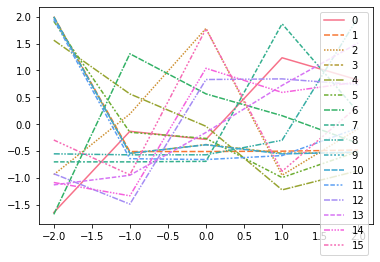

In [341]:
onoff=1
fr_other_field_relative_to_self_sw_df_onoff=fr_other_field_relative_to_self_sw_df.query('switch==@onoff')
toplot = fr_other_field_relative_to_self_sw_df_onoff.loc[ma,-2:2]
toplot=toplot.reset_index(drop=True)
toplot=scipy.stats.zscore(toplot,axis=1)
# sns.lineplot(data=toplot.melt(),x='variable',y='value',marker='o')
sns.lineplot(data=toplot.T)

In [355]:
ma=(fr_other_field_relative_to_self_sw_df[0]-fr_other_field_relative_to_self_sw_df[-1]) / fr_other_field_relative_to_self_sw_df['other_fr']<-0.2
ma&=fr_other_field_relative_to_self_sw_df['switch']==1




In [359]:
ma=(fr_other_field_relative_to_self_sw_df[0]-fr_other_field_relative_to_self_sw_df[-1]) / fr_other_field_relative_to_self_sw_df['other_fr']>0.2
ma&=fr_other_field_relative_to_self_sw_df['switch']==1




In [389]:
fr_other_field_relative_to_self_sw_df

-2         -1          0  \
e13_16f1 e13_16f1_210302 0 0 12  0.0 0   5.391809   9.690145  14.756929   
                                     1   9.597853  15.529220  12.449668   
                             13  2.0 0   5.090372   5.532009   7.235463   
                             22  1.0 0   4.683292   6.621108  11.304096   
                             25  3.0 0   4.439492   4.536599  11.460025   
...                                           ...        ...        ...   
e16_3m2  e16_3m2_211213  1 1 124 1.0 0   0.000567   1.454163   0.000000   
                                     1  18.057687  17.974986  13.643395   
                             157 0.0 0   4.874851   9.632381   4.772405   
                             192 0.0 0   0.250694   0.007166   1.029633   
                                 1.0 0   5.298149  11.642731   2.216628   

                                                1          2  corr_with_other  \
e13_16f1 e13_16f1_210302 0 0 12  0.0 0  10.835417  14.721401         0.588415   
                                     1  12.216831  22.064548         0.588415   
                             13  2.0 0   4.498768   6.110929         0.423758   
                             22  1.0 0   6.322049   5.034030         0.508944   
                             25  3.0 0  10.427361   5.549855         0.316699   
...                                           ...        ...              ...   
e16_3m2  e16_3m2_211213  1 1 124 1.0 0   1.925973   0.400758         0.655117   
                                     1  14.352489   8.495759         0.655117   
                             157 0.0 0   5.408492   7.073568         0.376121   
                             192 0.0 0   0.031437   0.489134         0.258368   
                                 1.0 0   3.355098   4.909155         0.258368   

                                        corr_with_other_pval  index_within  \
e13_16f1 e13_16f1_210302 0 0 12  0.0 0              0.021030           3.0   
                                     1              0.021030          10.0   
                             13  2.0 0              0.115471           9.0   
                             22  1.0 0              0.052680           5.0   
                             25  3.0 0              0.250113           2.0   
...                                                      ...           ...   
e16_3m2  e16_3m2_211213  1 1 124 1.0 0              0.015083           7.0   
                                     1              0.015083          24.0   
                             157 0.0 0              0.205290           8.0   
                             192 0.0 0              0.394044           5.0   
                                 1.0 0              0.394044          20.0   

                                         other_fr  other_loc    self_fr  \
e13_16f1 e13_16f1_210302 0 0 12  0.0 0  11.684902       53.0  21.044290   
                                     1  11.684902       53.0  21.044290   
                             13  2.0 0   5.289993       73.0  13.427116   
                             22  1.0 0   6.493593       48.0  12.460209   
                             25  3.0 0   7.299164       12.0   8.626704   
...                                           ...        ...        ...   
e16_3m2  e16_3m2_211213  1 1 124 1.0 0   7.399537        0.0   7.604276   
                                     1   7.399537        0.0   7.604276   
                             157 0.0 0   4.700573       40.0   7.491493   
                             192 0.0 0   3.100384       33.0   3.904058   
                                 1.0 0   3.904058       14.0   3.100384   

                                        self_loc  switch  trial_index  
e13_16f1 e13_16f1_210302 0 0 12  0.0 0      14.0     1.0          6.0  
                                     1      14.0     1.0         15.0  
                             13  2.0 0      93.0     1.0         14.0  
                             22  1.0 0      81.

In [402]:
fr_chg_population=fr_all_combine_tt_both.apply(lambda x:x.dropna().diff()/x.mean(),axis=1)

In [416]:
fr_all_combine_tt_both_vals=fr_chg_population.values.flatten()
fr_all_combine_tt_both_vals=fr_all_combine_tt_both_vals[~np.isnan(fr_all_combine_tt_both_vals)]

(array([   499.,   1163.,   3644.,  17301., 107116., 115540.,  18136.,
          3853.,   1222.,    494.,    246.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <BarContainer object of 11 artists>)

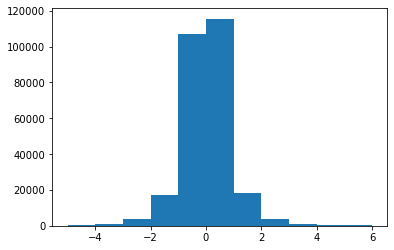

In [418]:

plt.hist(fr_all_combine_tt_both_vals,bins=np.arange(-5,7))

<Axes: >

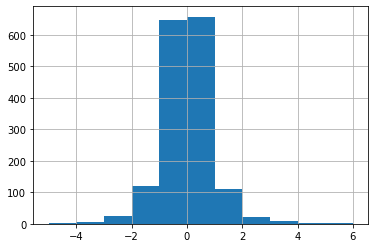

In [410]:
bins=[-5,-4,-3,-3,-2,-1,0,1,2,3,4,5,6]
fr_chg.hist(bins=bins)

<Axes: >

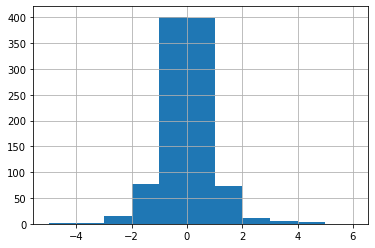

In [431]:
fr_chg.loc[fr_other_field_relative_to_self_sw_df['switch']==1].hist(bins=bins)

<Axes: >

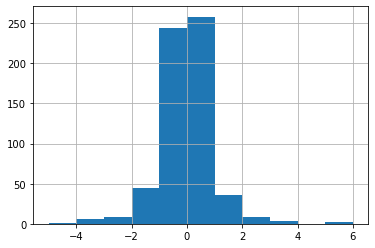

In [432]:
fr_chg.loc[fr_other_field_relative_to_self_sw_df['switch']==-1].hist(bins=bins)

<Figure size 432x288 with 0 Axes>

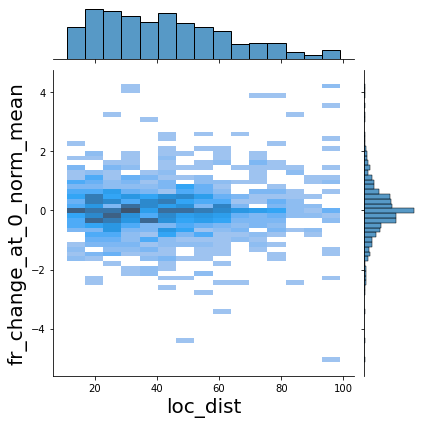

<Figure size 432x288 with 0 Axes>

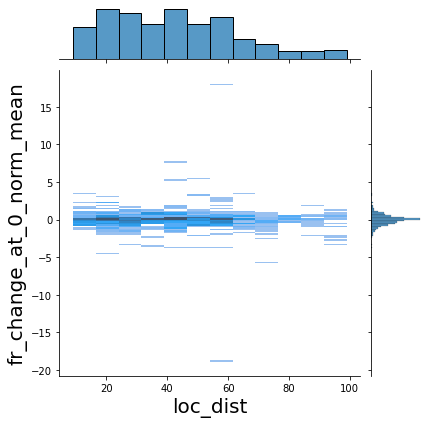

In [451]:
fr_other_field_relative_to_self_sw_df['loc_dist']=(fr_other_field_relative_to_self_sw_df['self_loc']-fr_other_field_relative_to_self_sw_df['other_loc']).abs()
for onoff in [1,-1]:
    fig=plt.figure()

    sns.jointplot(data=fr_other_field_relative_to_self_sw_df.query('switch==@onoff'),x='loc_dist',y='fr_change_at_0_norm_mean',kind='hist')


/tmp/ipykernel_1128008/965604601.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/965604601.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_1128008/965604601.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/965604601.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/965604601.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
/tmp/ipykernel_1128008/965604601.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]
/tmp/ipykernel_1128008

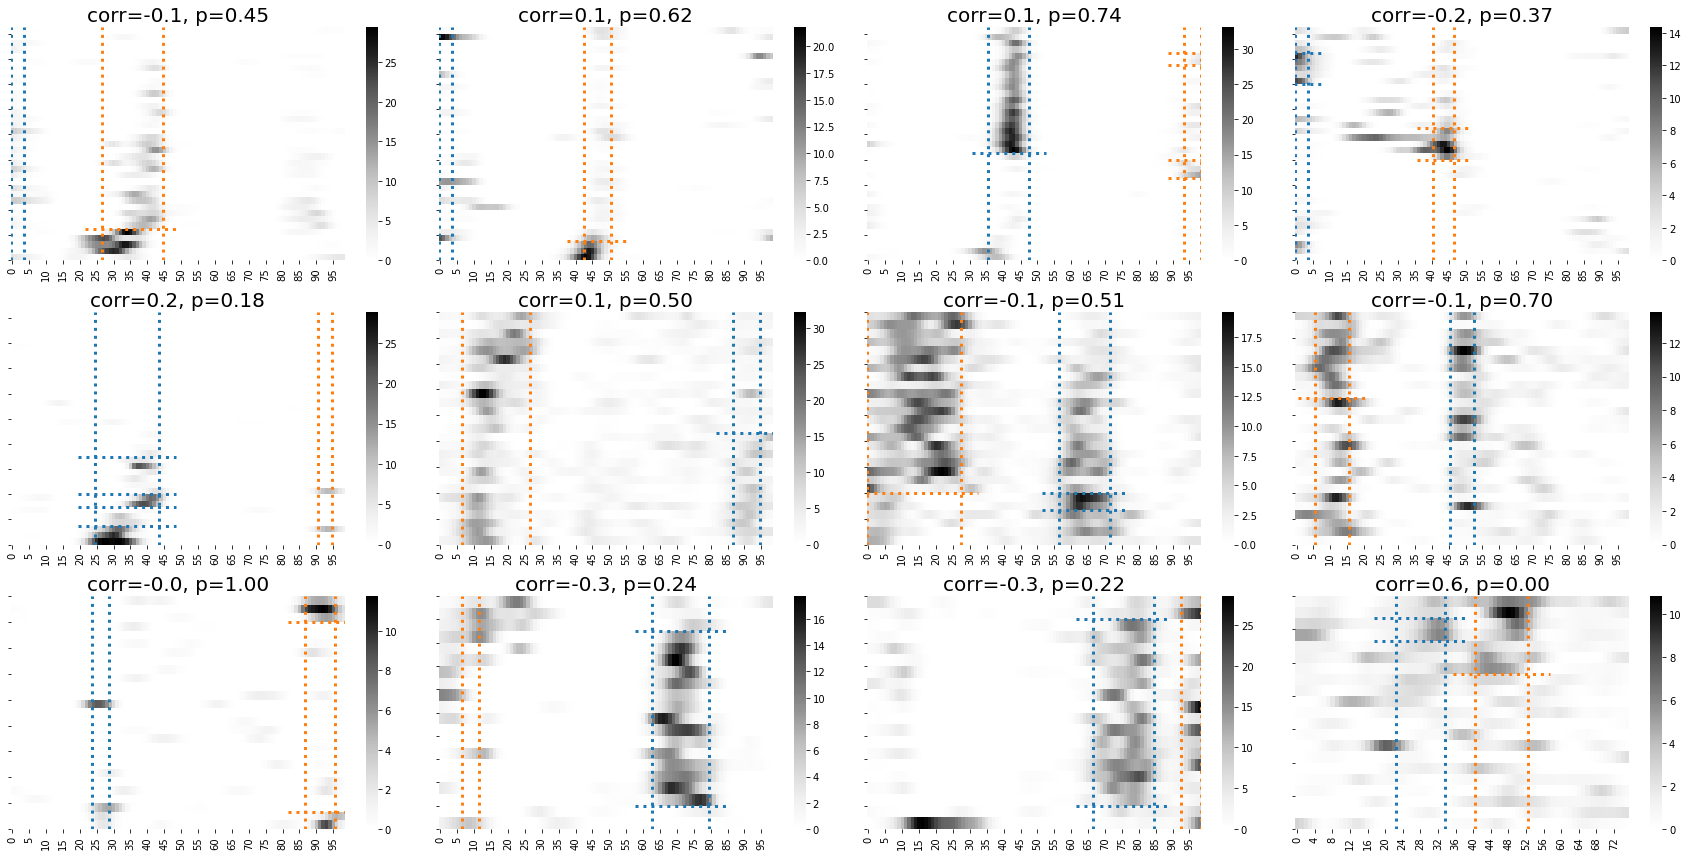

In [438]:
# peri switch, examples, different scenarios
fr_chg=fr_other_field_relative_to_self_sw_df['fr_change_at_0_norm_mean']

thresh=0.5#0.2
# ma=fr_chg.abs()<thresh
# ma=fr_chg<-thresh
ma=fr_chg>thresh
onoff = -1
ma&=fr_other_field_relative_to_self_sw_df['switch']==onoff

k=2
toplot_inds=np.arange(12*k,12*(k+1))
nplots=len(toplot_inds)
fig,axs=ph.subplots_wrapper(nplots)
for ii,jj in enumerate(toplot_inds):
    ax=axs.ravel()[ii]
    row=fr_other_field_relative_to_self_sw_df.loc[ma].iloc[jj]
    corr = row['corr_with_other']
    pval_corr = row['corr_with_other_pval']
    ani,sess,task_ind,tt,uid=row.name[:-2]
    fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess]
    all_fields = all_fields_recombined_all.loc[ani,sess]
    changes_df = changes_df_all.loc[ani,sess]
    spk_beh_df = spk_beh_df_all.loc[ani,sess]
    index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)
    try:
        fig,ax=plot_fm.plot_ratemap_one_neuron_all_fields_using_changes_df(fr_map_trial_df,all_fields,changes_df,index_within_to_trial_index_df,
                                           task_ind,tt,uid,flipy=True,
                                           fig=fig,ax=ax,shuffle_ratemap=False
                                          )
        ax.set(xlabel='',ylabel='',title=f'corr={corr:.01f}, p={pval_corr:.02f}')
    except:
        pass
plt.tight_layout()

In [205]:
fr_other_field_relative_to_self_sw_df.unstack()

-2         -1          0  \
e13_16f1 e13_16f1_210302 0 0 9   1.0 0        NaN        NaN        NaN   
                                 3.0 0   7.094134   9.242107   8.231941   
                             33  0.0 0        NaN        NaN        NaN   
                                 1.0 0        NaN        NaN        NaN   
                             64  1.0 0        NaN        NaN        NaN   
...                                           ...        ...        ...   
e16_3m2  e16_3m2_211213  1 1 100 1.0 1        NaN        NaN        NaN   
                             124 1.0 0   0.000567   1.454163        0.0   
                                     1  18.057687  17.974986  13.643395   
                             192 0.0 0        NaN        NaN        NaN   
                                 1.0 0   5.298149  11.642731   2.216628   

                                                1          2    3          4  \
e13_16f1 e13_16f1_210302 0 0 9   1.0 0        NaN  12.237836  NaN  16.172058   
                                 3.0 0  14.511862   6.061847  NaN        NaN   
                             33  0.0 0        NaN        NaN  NaN  12.123159   
                                 1.0 0        NaN        NaN  NaN        NaN   
                             64  1.0 0        0.0   1.870447  NaN   6.710785   
...                                           ...        ...  ...        ...   
e16_3m2  e16_3m2_211213  1 1 100 1.0 1        NaN        NaN  NaN        NaN   
                             124 1.0 0   1.925973   0.400758  NaN        NaN   
                                     1  14.352489   8.495759  NaN        NaN   
                             192 0.0 0        NaN        NaN  NaN        NaN   
                                 1.0 0   3.355098   4.909155  NaN        NaN   

                                                5          6         7  ...  \
e13_16f1 e13_16f1_210302 0 0 9   1.0 0  24.926374  11.487664       NaN  ...   
                                 3.0 0        NaN        NaN       NaN  ...   
                             33  0.0 0        NaN   5.516308  3.004263  ...   
                                 1.0 0        NaN        NaN       NaN  ...   
                             64  1.0 0   0.837797   1.720324       NaN  ...   
...                                           ...        ...       ...  ...   
e16_3m2  e16_3m2_211213  1 1 100 1.0 1        NaN        NaN       NaN  ...   
                             124 1.0 0        NaN        NaN       NaN  ...   
                                     1        NaN        NaN       NaN  ...   
                             192 0.0 0   0.489134        0.0       NaN  ...   
                                 1.0 0        NaN        NaN       NaN  ...   

                                         35   36   37 index_within  \
e13_16f1 e13_16f1_210302 0 0 9   1.0 0  NaN  NaN  NaN         10.0   
                                 3.0 0  NaN  NaN  NaN          8.0   
                             33  0.0 0  NaN  NaN  NaN         14.0   
                                 1.0 0  NaN  NaN  NaN         20.0   
                             64  1.0 0  NaN  NaN  NaN          6.0   
...                                     ...  ...  ...          ...   
e16_3m2  e16_3m2_211213  1 1 100 1.0 1  NaN  NaN  NaN         20.0   
                             124 1.0 0  NaN  NaN  NaN          7.0   
                                     1  NaN  NaN  NaN         24.0   
                             192 0.0 0  NaN  NaN  NaN          9.0   
                                 1.0 0  NaN  NaN  NaN         20.0   

                                                                                 other_fr  \
e13_16f1 e13_16f1_210302 0 0 9   1.0 0  0      0.529698
1      5.775591
4      8.27123...   
                                 3.0 0  0      4.551478
1     13.045322
2     13.50072...   
                             33  0.0 0  0      7.370064
1      9.377418
4      7.61368...   
                       